In [41]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

<IPython.core.display.Javascript object>


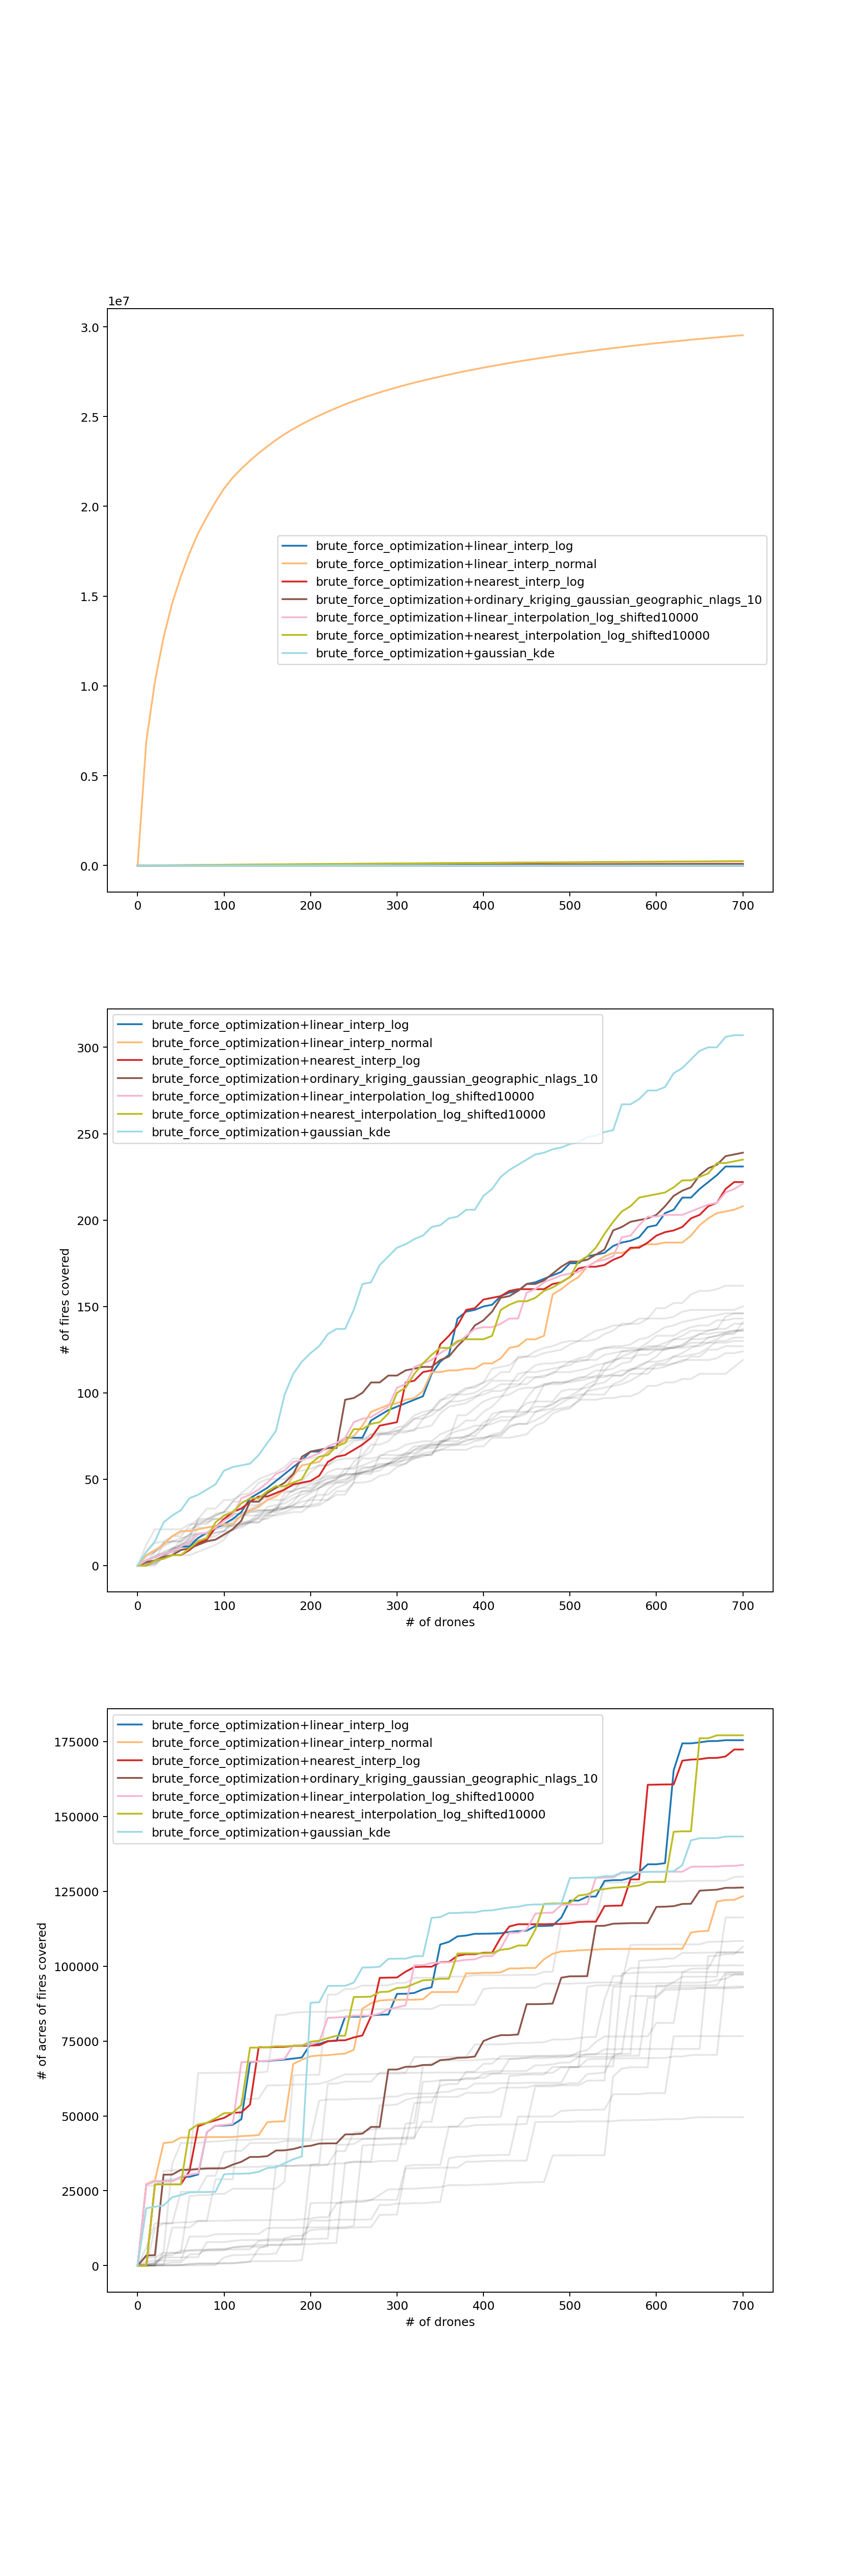

In [42]:
%matplotlib notebook
files_without_coverages = ['./tradeoff_results/brute_force_optimization+linear_interp_log', './tradeoff_results/brute_force_optimization+linear_interp_normal',
                               './tradeoff_results/brute_force_optimization+nearest_interp_log','./tradeoff_results/brute_force_optimization+ordinary_kriging_gaussian_geographic_nlags_10']
randruns = ['./tradeoff_results/rands/random+gaussian_kde_' + str(i) for i in range(1,16)]
files_with_coverages = ['./tradeoff_results/brute_force_optimization+linear_interpolation_log_shifted10000', './tradeoff_results/brute_force_optimization+nearest_interpolation_log_shifted10000', './tradeoff_results/brute_force_optimization+gaussian_kde']
files = files_without_coverages + files_with_coverages
xs, y1s, y2s, y3s = [], [], [], []

for file in files:
    with open(file, 'rb') as fp:
        res = pickle.load(fp)
        x = res[0]
        y1 = res[1]
        y2 = res[2]
        y3 = res[3]
        xs.append(x)
        y1s.append(y1)
        y2s.append(y2)
        y3s.append(y3)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (10,30))

cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in np.linspace(0, 1, len(xs))]
colornum = 0
xrand = []
y1rand = []
y2rand = []
y3rand = []
for file in randruns:
    with open(file, 'rb') as fp:
        res = pickle.load(fp)
        x = res[0]
        y1 = res[1]
        y2 = res[2]
        y3 = res[3]
        xrand.append(x)
        y1rand.append(y1)
        y2rand.append(y2)
        y3rand.append(y3)
for ind in range(len(xrand)):
    ax[0].plot(xrand[ind], y1rand[ind], color = "black", alpha = 0.1)
    ax[1].plot(xrand[ind], y2rand[ind], color = "black", alpha = 0.1)
    ax[2].plot(xrand[ind], y3rand[ind], color = "black", alpha = 0.1)
    
for ind in range(len(xs)):
    ax[0].plot(xs[ind], y1s[ind], label = files[ind].split("/")[-1], color = colors[colornum])
    ax[1].plot(xs[ind], y2s[ind], label = files[ind].split("/")[-1], color = colors[colornum])
    ax[2].plot(xs[ind], y3s[ind], label = files[ind].split("/")[-1], color = colors[colornum])
    colornum += 1
#     colornum %= len(colors)
    
ax[0].legend()
ax[1].legend()
ax[2].legend()


# ax[0].set_prop_cycle('color', colors)

ax[1].set_ylabel("# of fires covered")
ax[1].set_xlabel("# of drones")
ax[2].set_ylabel("# of acres of fires covered")
ax[2].set_xlabel("# of drones")
plt.show()

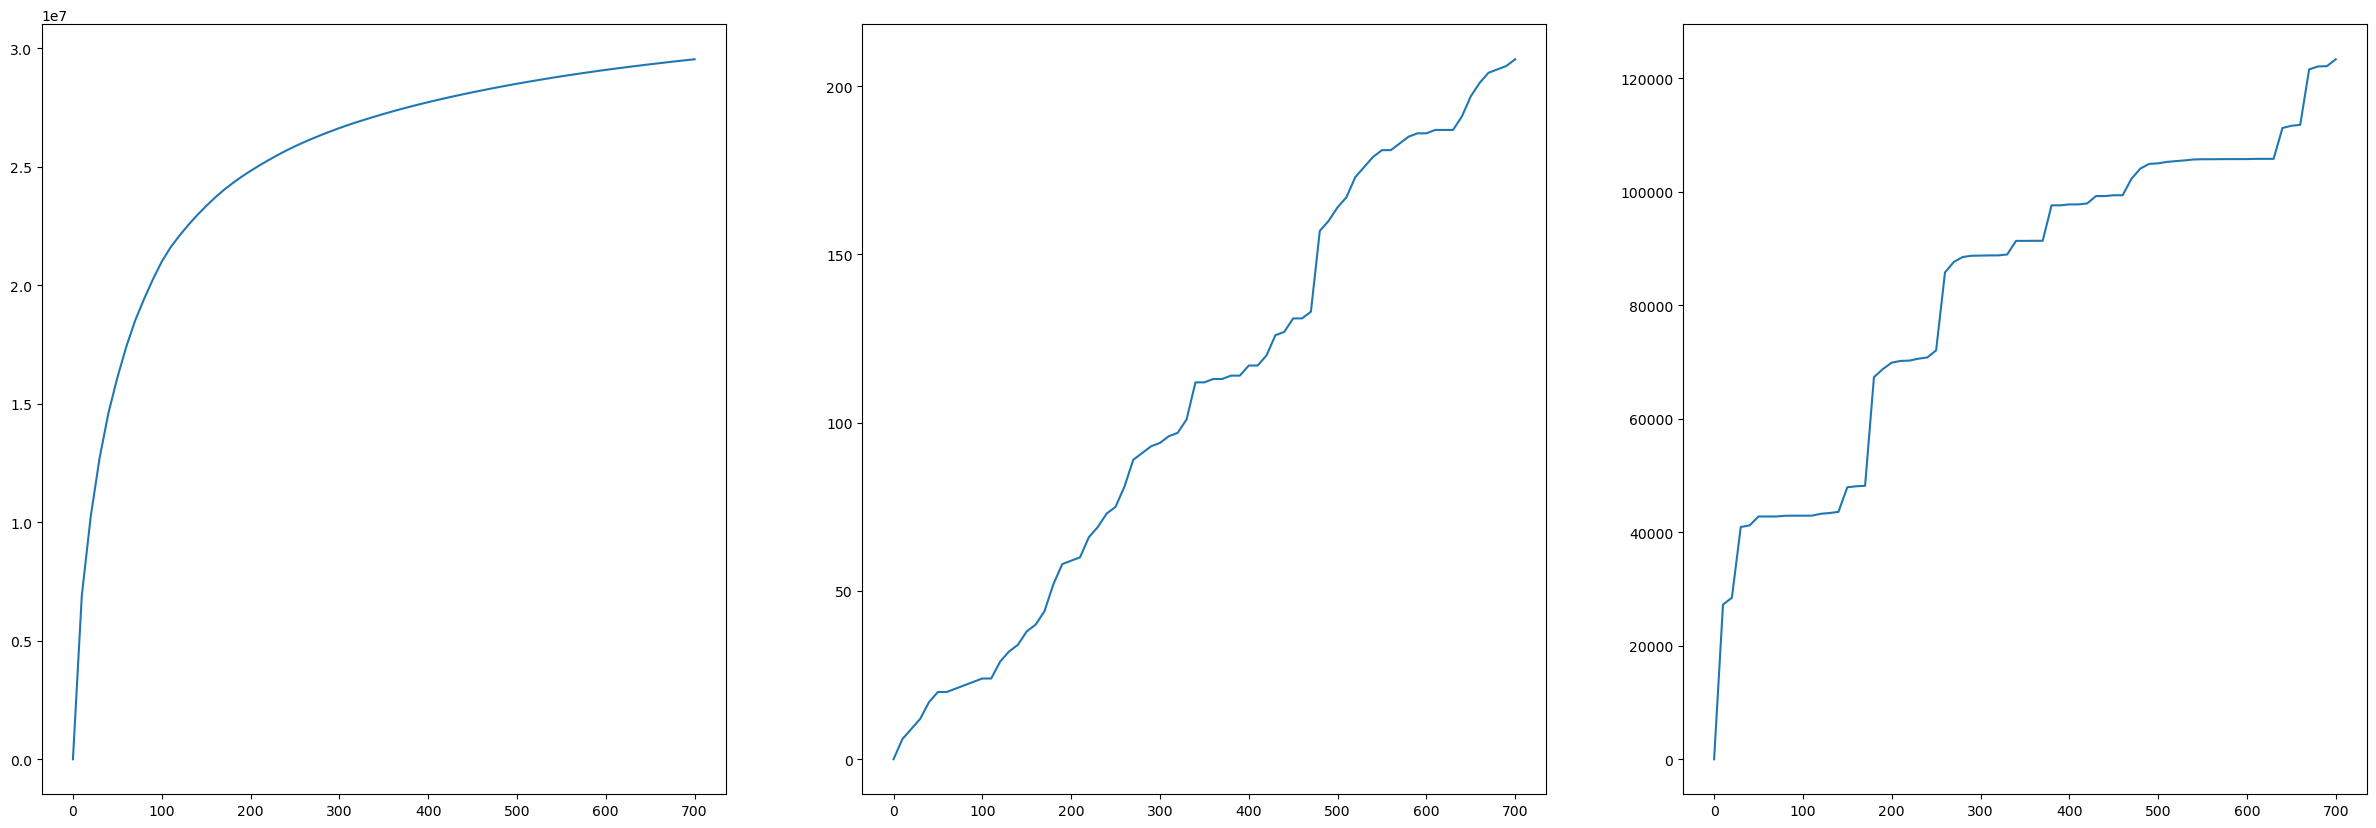

In [18]:
with open('./tradeoff_results/brute_force_optimization+linear_interp_normal', 'rb') as fp:
    x, y1, y2, y3 = pickle.load(fp)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (30,10))
ax[0].plot(x, y1)
ax[1].plot(x, y2)
ax[2].plot(x, y3)

In [43]:
####### IMPORT DATA
import pandas as pd
import geopandas
cell_geo = pd.read_pickle("./dataframes/cell_geometry")
cell = geopandas.GeoDataFrame(cell_geo, columns=['geometry'], 
                                 crs='epsg:4326')

jsonfile = ('./mygeodata/fire_station_point.geojson')
fire_station_points = geopandas.read_file(jsonfile)

jsonfile = ('./ark28722-s73w23-geojson.json')
world = geopandas.read_file(jsonfile)
world = world.dissolve()

fires = pd.read_pickle("./dataframes/all_fires")
fires = fires[~fires["GIS_ACRES"].isnull()]
fires = fires[~fires.duplicated()]
fires = fires[~fires[["FIRE_NAME", "INC_NUM", "ALARM_DATE", "CONT_DATE", "CAUSE", "geometry"]].duplicated()]

fires = fires.loc[(fires["YEAR"] >= 2020) & (fires["YEAR"] <= 2023) & (fires["MONTH"] >= 6) & (fires["MONTH"] <= 10)]

def countcoveredchoose(coverages):
    totalcovered = 0
    ansar = np.array([False for i in range(len(fires))])
    for x in coverages:
        indx = x[1]
        minx, miny, maxx, maxy = cell["geometry"][indx].bounds
        if (x[2] == 1):
            pos = (minx, miny)
        if (x[2] == 2):
            pos = (minx, maxy-5*12/n_cells)
        if (x[2] == 3):
            pos = (maxx-5*12/n_cells, maxy-5*12/n_cells)
        if (x[2] == 4):
            pos = (maxx-5*12/n_cells, miny)
        if (x[2] == 5):
            pos = (minx-2*12/n_cells, miny)
        if (x[2] == 6):
            pos = (minx-2*12/n_cells, maxy-5*12/n_cells)
        if (x[2] == 7):
            pos = (maxx-5*12/n_cells, miny-2*12/n_cells)
        if (x[2] == 8):
            pos = (minx, miny-2*12/n_cells)
        if (x[2] == 9):
            pos = (minx-2*12/n_cells, miny-2*12/n_cells)
        polygon = Polygon([(pos[0], pos[1]), (pos[0] + 5*12/n_cells, pos[1]), (pos[0] + 5*12/n_cells, pos[1] + 5*12/n_cells), (pos[0], pos[1] + 5*12/n_cells)])
#         coverage_bounds = (pos[0], pos[1], , pos[1] + 5*12/n_cells)
#         print(polygon)
        ansar = np.logical_or(ansar, fires.overlaps(polygon))
        ansar = np.logical_or(ansar, fires.within(polygon))
        ansar = np.logical_or(ansar, fires.contains(polygon))
    return ansar

<IPython.core.display.Javascript object>


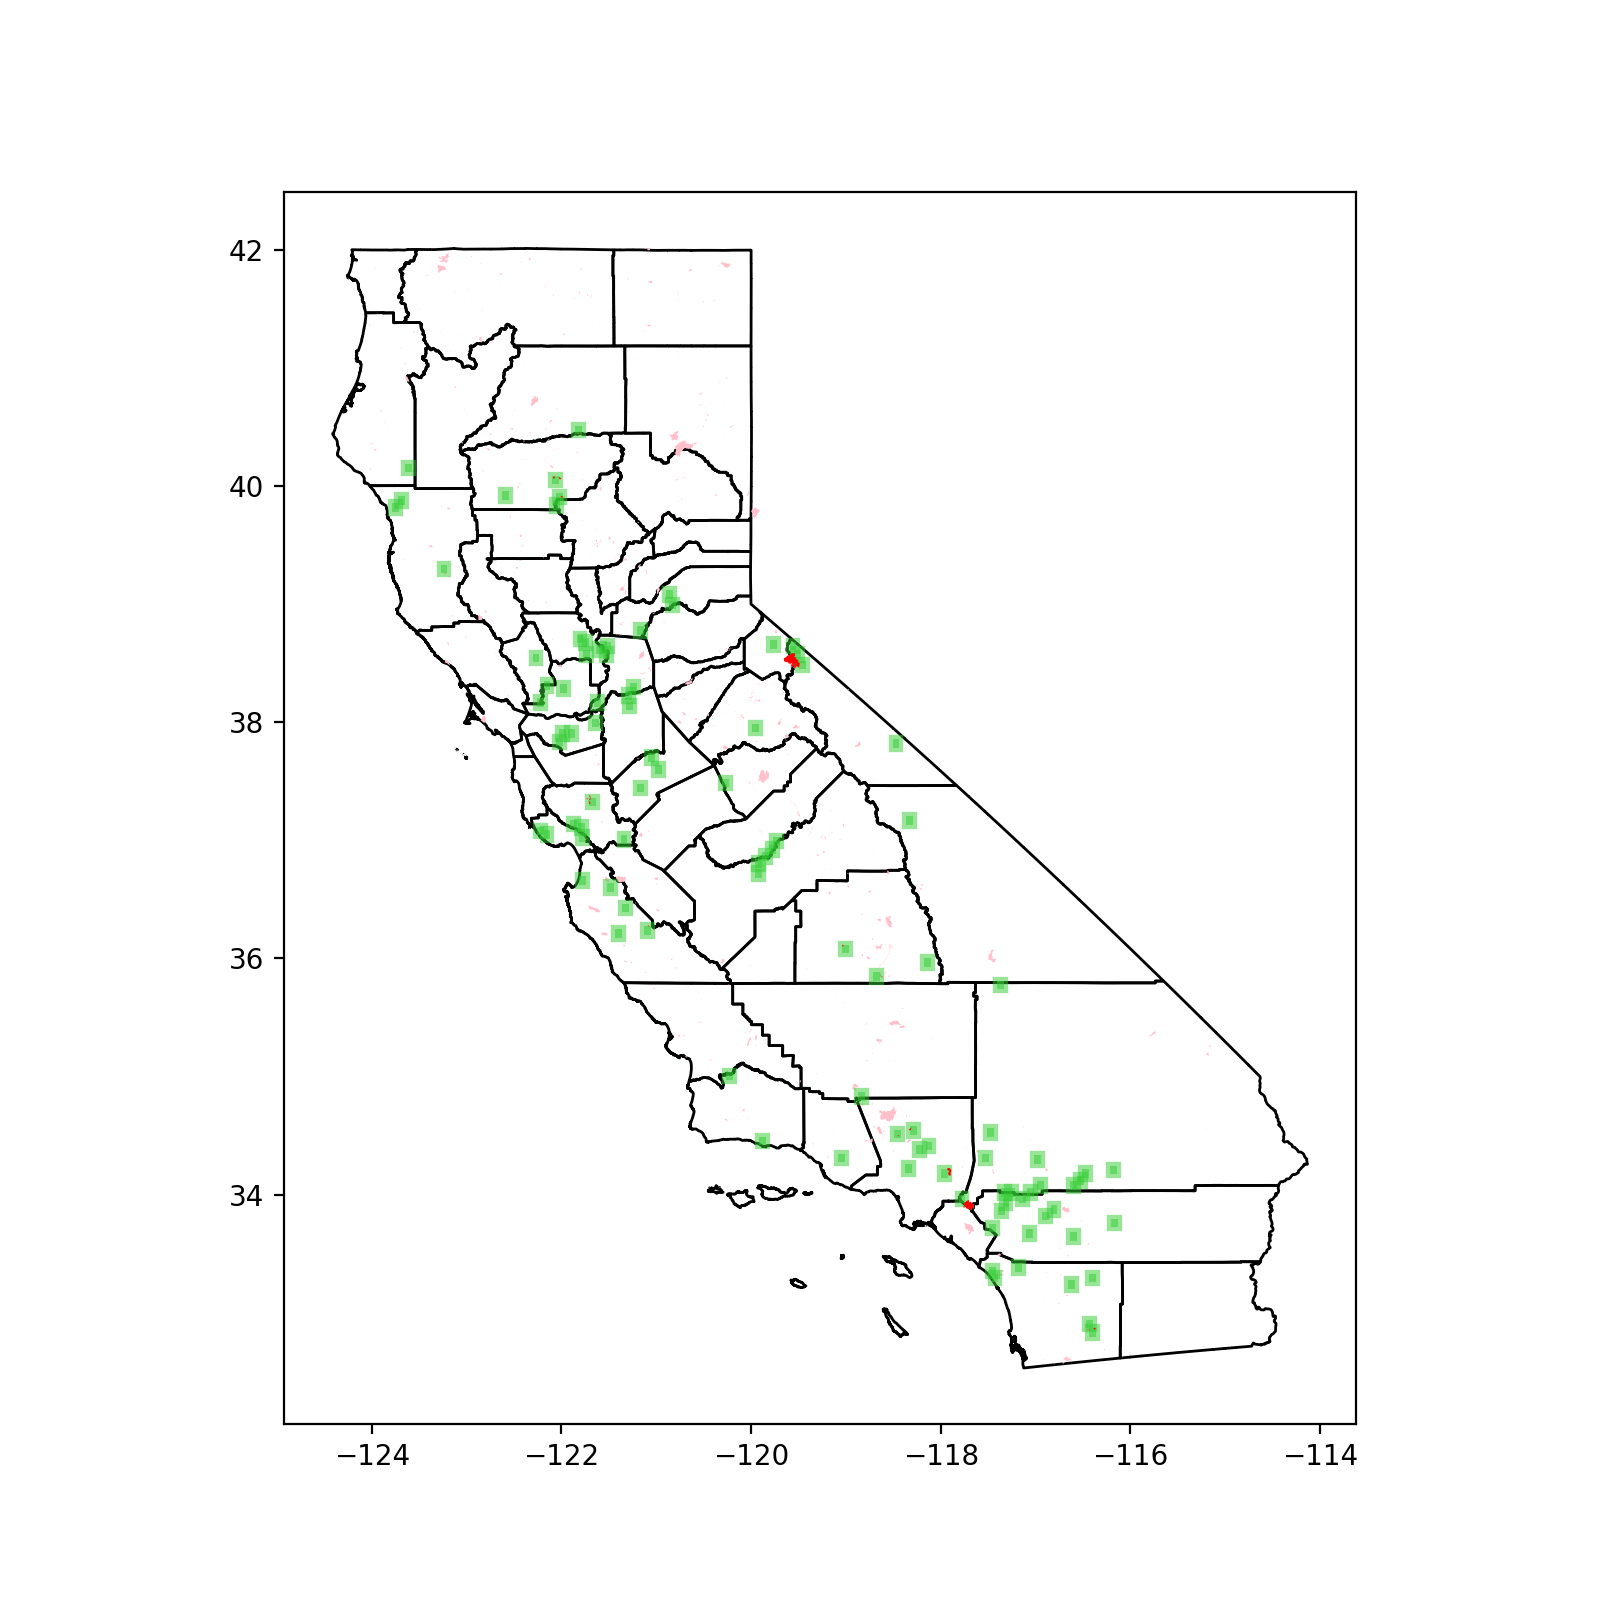

/Users/christopher/anaconda3/lib/python3.10/site-packages/shapely/predicates.py:853: RuntimeWarning: invalid value encountered in overlaps
  return lib.overlaps(a, b, **kwargs)


<Axes: >

In [24]:
###### Plotting Coverages
from shapely.geometry import Polygon

%matplotlib notebook
filename = "./tradeoff_results/brute_force_optimization+nearest_interpolation_log_shifted10000"
plot_coverages = []
with open(filename, 'rb') as fp:
    res = pickle.load(fp)
    plot_coverages = res[4][10][1]


# plot_coverages
n_cells = 828
ax = world.to_crs(cell.crs).plot(color = "none", edgecolor = 'black', figsize = (8,8))
fires.plot(ax = ax, color = "pink")
for x in plot_coverages:
    indx = x[1]
    minx, miny, maxx, maxy = cell["geometry"][indx].bounds
    if (x[2] == 1):
        pos = (minx, miny)
    if (x[2] == 2):
        pos = (minx, maxy-5*12/n_cells)
    if (x[2] == 3):
        pos = (maxx-5*12/n_cells, maxy-5*12/n_cells)
    if (x[2] == 4):
        pos = (maxx-5*12/n_cells, miny)
    if (x[2] == 5):
        pos = (minx-2*12/n_cells, miny)
    if (x[2] == 6):
        pos = (minx-2*12/n_cells, maxy-5*12/n_cells)
    if (x[2] == 7):
        pos = (maxx-5*12/n_cells, miny-2*12/n_cells)
    if (x[2] == 8):
        pos = (minx, miny-2*12/n_cells)
    if (x[2] == 9):
        pos = (minx-2*12/n_cells, miny-2*12/n_cells)
    rect = plt.Rectangle(pos, 5*12/n_cells, 5*12/n_cells, color="limegreen", linewidth=3, alpha = 0.5)
    ax = ax or plt.gca()
    ax.add_patch(rect)
fires[countcoveredchoose(plot_coverages)].plot(ax= ax, color = "red")

<IPython.core.display.Javascript object>


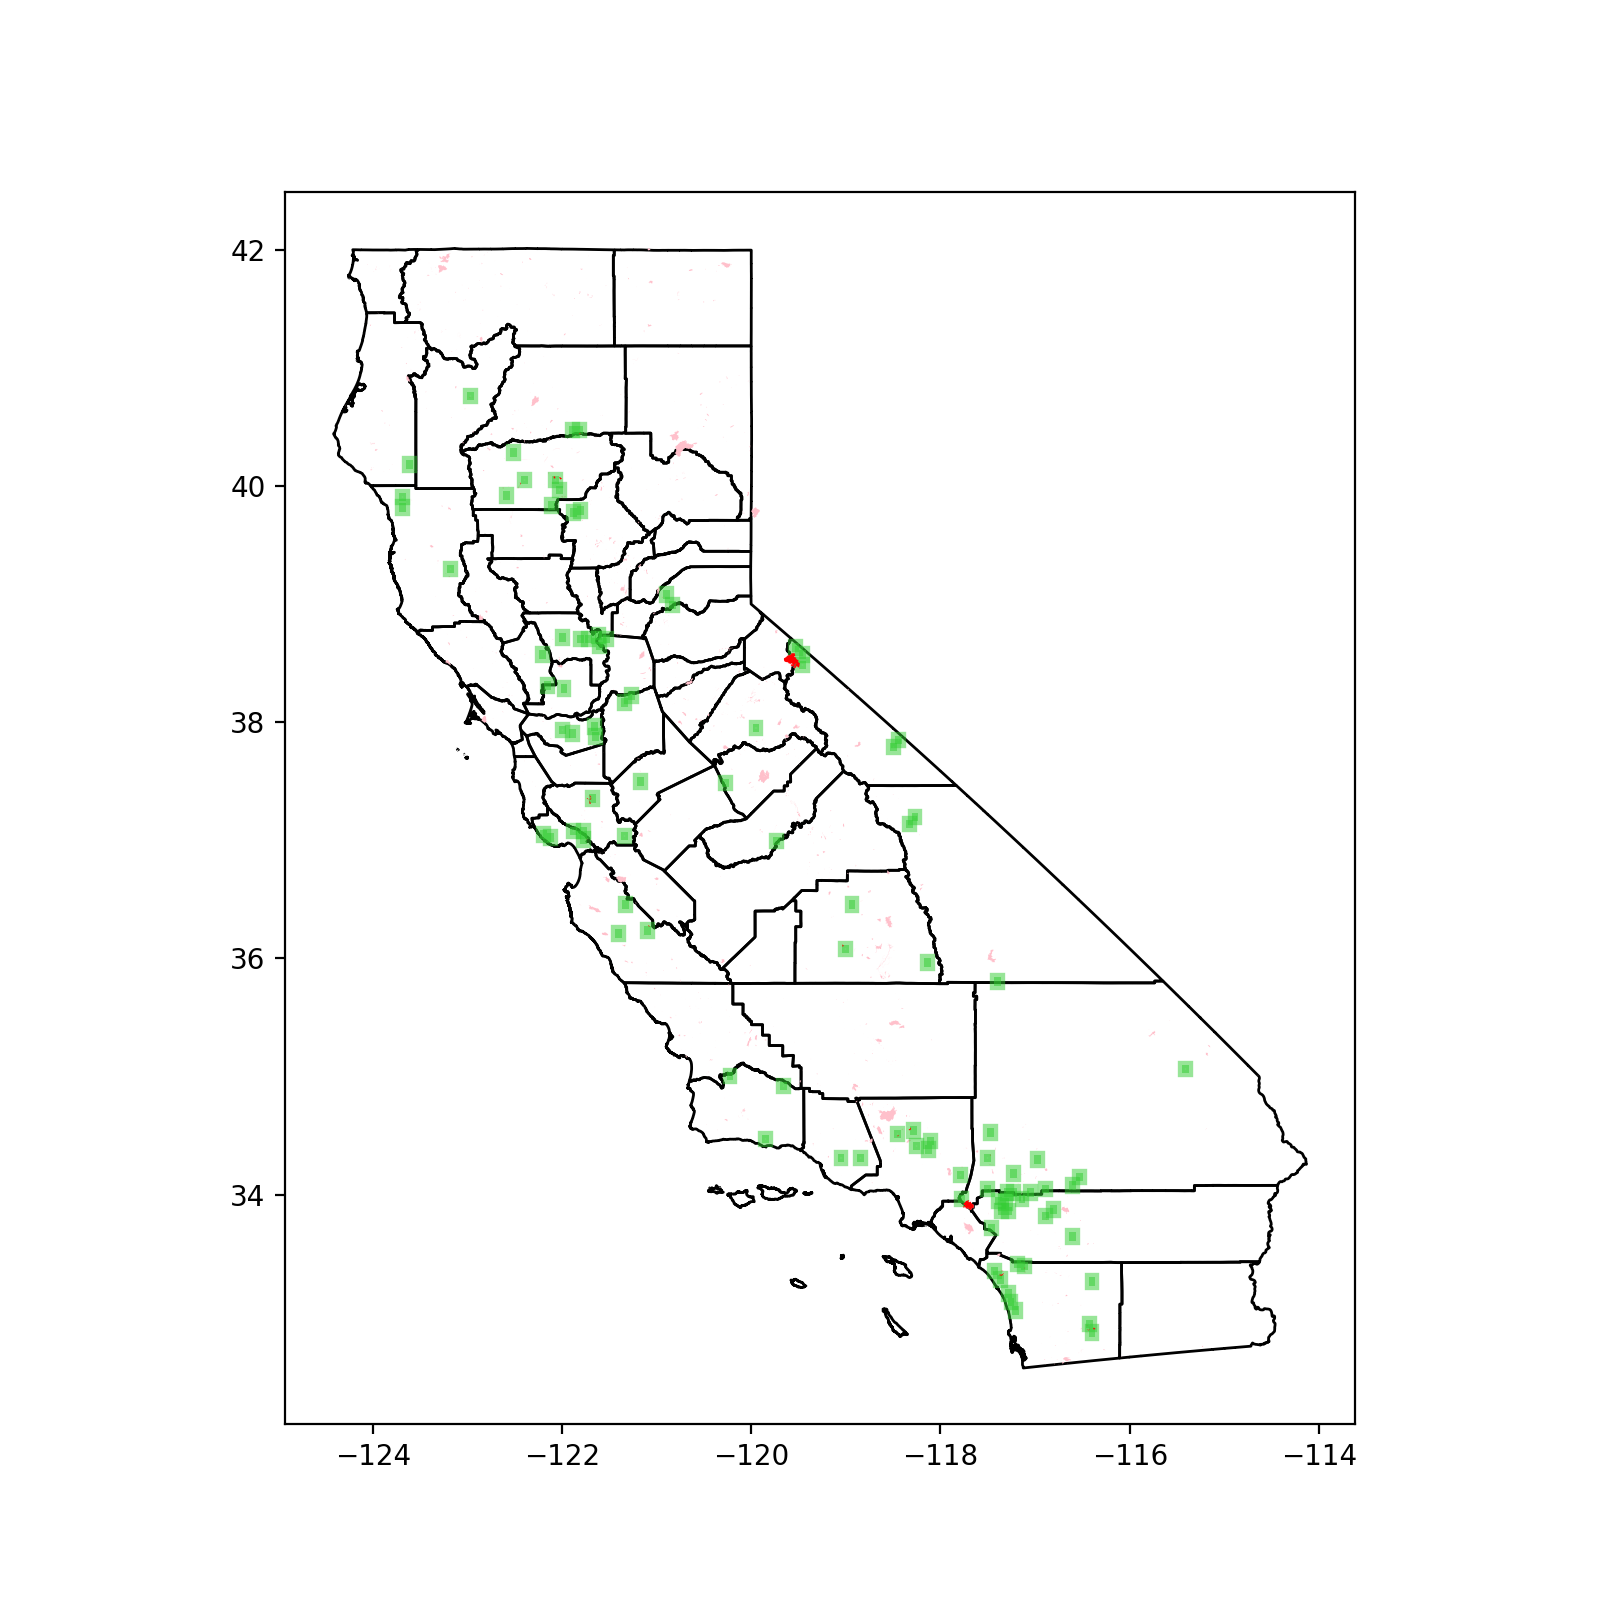

/Users/christopher/anaconda3/lib/python3.10/site-packages/shapely/predicates.py:853: RuntimeWarning: invalid value encountered in overlaps
  return lib.overlaps(a, b, **kwargs)


<Axes: >

In [25]:
###### Plotting Coverages
from shapely.geometry import Polygon

%matplotlib notebook
filename = "./tradeoff_results/brute_force_optimization+linear_interpolation_log_shifted10000"
plot_coverages = []
with open(filename, 'rb') as fp:
    res = pickle.load(fp)
    plot_coverages = res[4][10][1]


# plot_coverages
n_cells = 828
ax = world.to_crs(cell.crs).plot(color = "none", edgecolor = 'black', figsize = (8,8))
fires.plot(ax = ax, color = "pink")
for x in plot_coverages:
    indx = x[1]
    minx, miny, maxx, maxy = cell["geometry"][indx].bounds
    if (x[2] == 1):
        pos = (minx, miny)
    if (x[2] == 2):
        pos = (minx, maxy-5*12/n_cells)
    if (x[2] == 3):
        pos = (maxx-5*12/n_cells, maxy-5*12/n_cells)
    if (x[2] == 4):
        pos = (maxx-5*12/n_cells, miny)
    if (x[2] == 5):
        pos = (minx-2*12/n_cells, miny)
    if (x[2] == 6):
        pos = (minx-2*12/n_cells, maxy-5*12/n_cells)
    if (x[2] == 7):
        pos = (maxx-5*12/n_cells, miny-2*12/n_cells)
    if (x[2] == 8):
        pos = (minx, miny-2*12/n_cells)
    if (x[2] == 9):
        pos = (minx-2*12/n_cells, miny-2*12/n_cells)
    rect = plt.Rectangle(pos, 5*12/n_cells, 5*12/n_cells, color="limegreen", linewidth=3, alpha = 0.5)
    ax = ax or plt.gca()
    ax.add_patch(rect)
fires[countcoveredchoose(plot_coverages)].plot(ax= ax, color = "red")


<IPython.core.display.Javascript object>


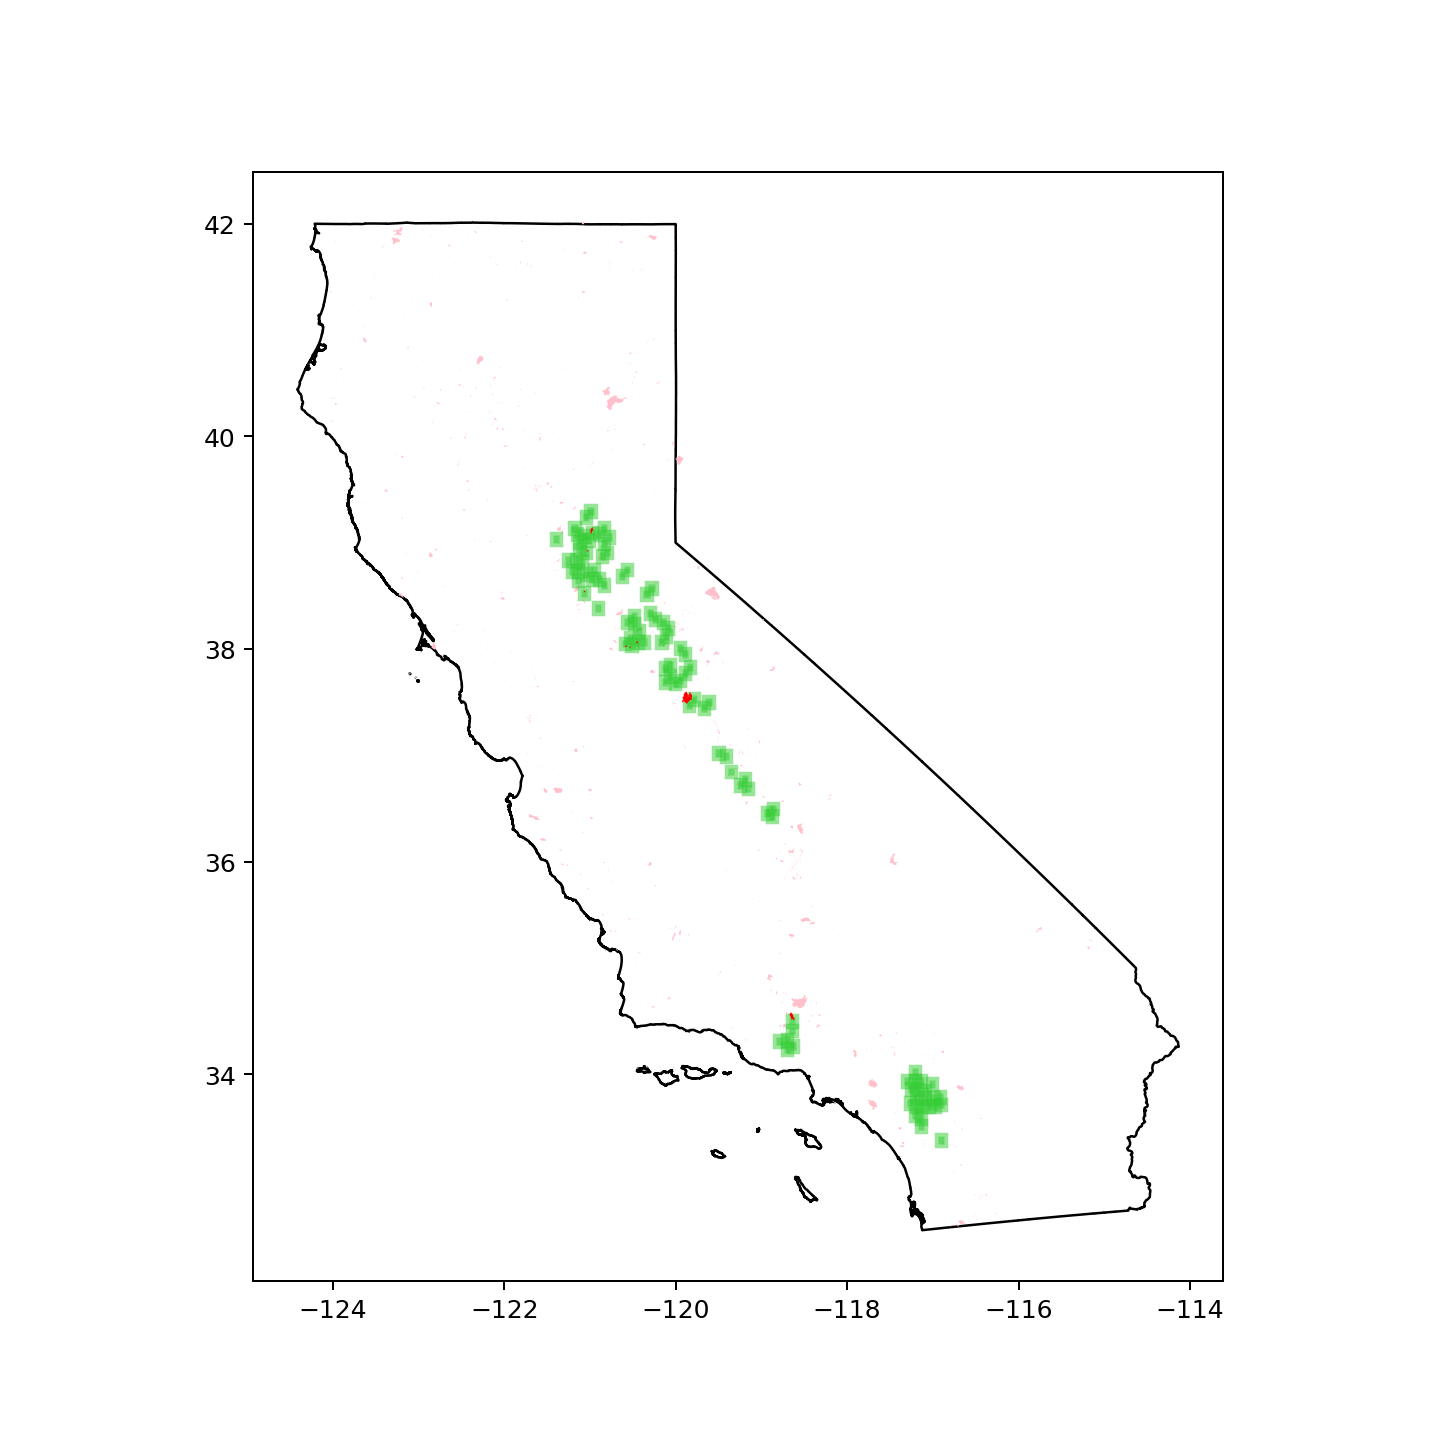

/Users/christopher/anaconda3/lib/python3.10/site-packages/shapely/predicates.py:853: RuntimeWarning: invalid value encountered in overlaps
  return lib.overlaps(a, b, **kwargs)


<Axes: >

In [44]:
###### Plotting Coverages
from shapely.geometry import Polygon

%matplotlib notebook
filename = "./tradeoff_results/brute_force_optimization+gaussian_kde"
plot_coverages = []
with open(filename, 'rb') as fp:
    res = pickle.load(fp)
    plot_coverages = res[4][10][1]


# plot_coverages
n_cells = 828
ax = world.to_crs(cell.crs).plot(color = "none", edgecolor = 'black', figsize = (8,8))
fires.plot(ax = ax, color = "pink")
for x in plot_coverages:
    indx = x[1]
    minx, miny, maxx, maxy = cell["geometry"][indx].bounds
    if (x[2] == 1):
        pos = (minx, miny)
    if (x[2] == 2):
        pos = (minx, maxy-5*12/n_cells)
    if (x[2] == 3):
        pos = (maxx-5*12/n_cells, maxy-5*12/n_cells)
    if (x[2] == 4):
        pos = (maxx-5*12/n_cells, miny)
    if (x[2] == 5):
        pos = (minx-2*12/n_cells, miny)
    if (x[2] == 6):
        pos = (minx-2*12/n_cells, maxy-5*12/n_cells)
    if (x[2] == 7):
        pos = (maxx-5*12/n_cells, miny-2*12/n_cells)
    if (x[2] == 8):
        pos = (minx, miny-2*12/n_cells)
    if (x[2] == 9):
        pos = (minx-2*12/n_cells, miny-2*12/n_cells)
    rect = plt.Rectangle(pos, 5*12/n_cells, 5*12/n_cells, color="limegreen", linewidth=3, alpha = 0.5)
    ax = ax or plt.gca()
    ax.add_patch(rect)
fires[countcoveredchoose(plot_coverages)].plot(ax= ax, color = "red")

In [30]:
len(fires)
np.sum(fires["GIS_ACRES"])

473360.980263412

In [47]:
####### PLOTTING
import matplotlib.colors as colors

def free_plotter(dataset):
    cell["interpolated_value"] = dataset
    cell["interpolated_value"] = cell["interpolated_value"].replace(np.nan, 0)
    ax = cell.plot(column='interpolated_value', figsize=(10, 10), cmap='plasma', legend=True)
    world.to_crs(cell.crs).plot(ax = ax, color = "none", edgecolor = 'black', figsize = (8,8), linewidth=1.2)
    return ax

<IPython.core.display.Javascript object>


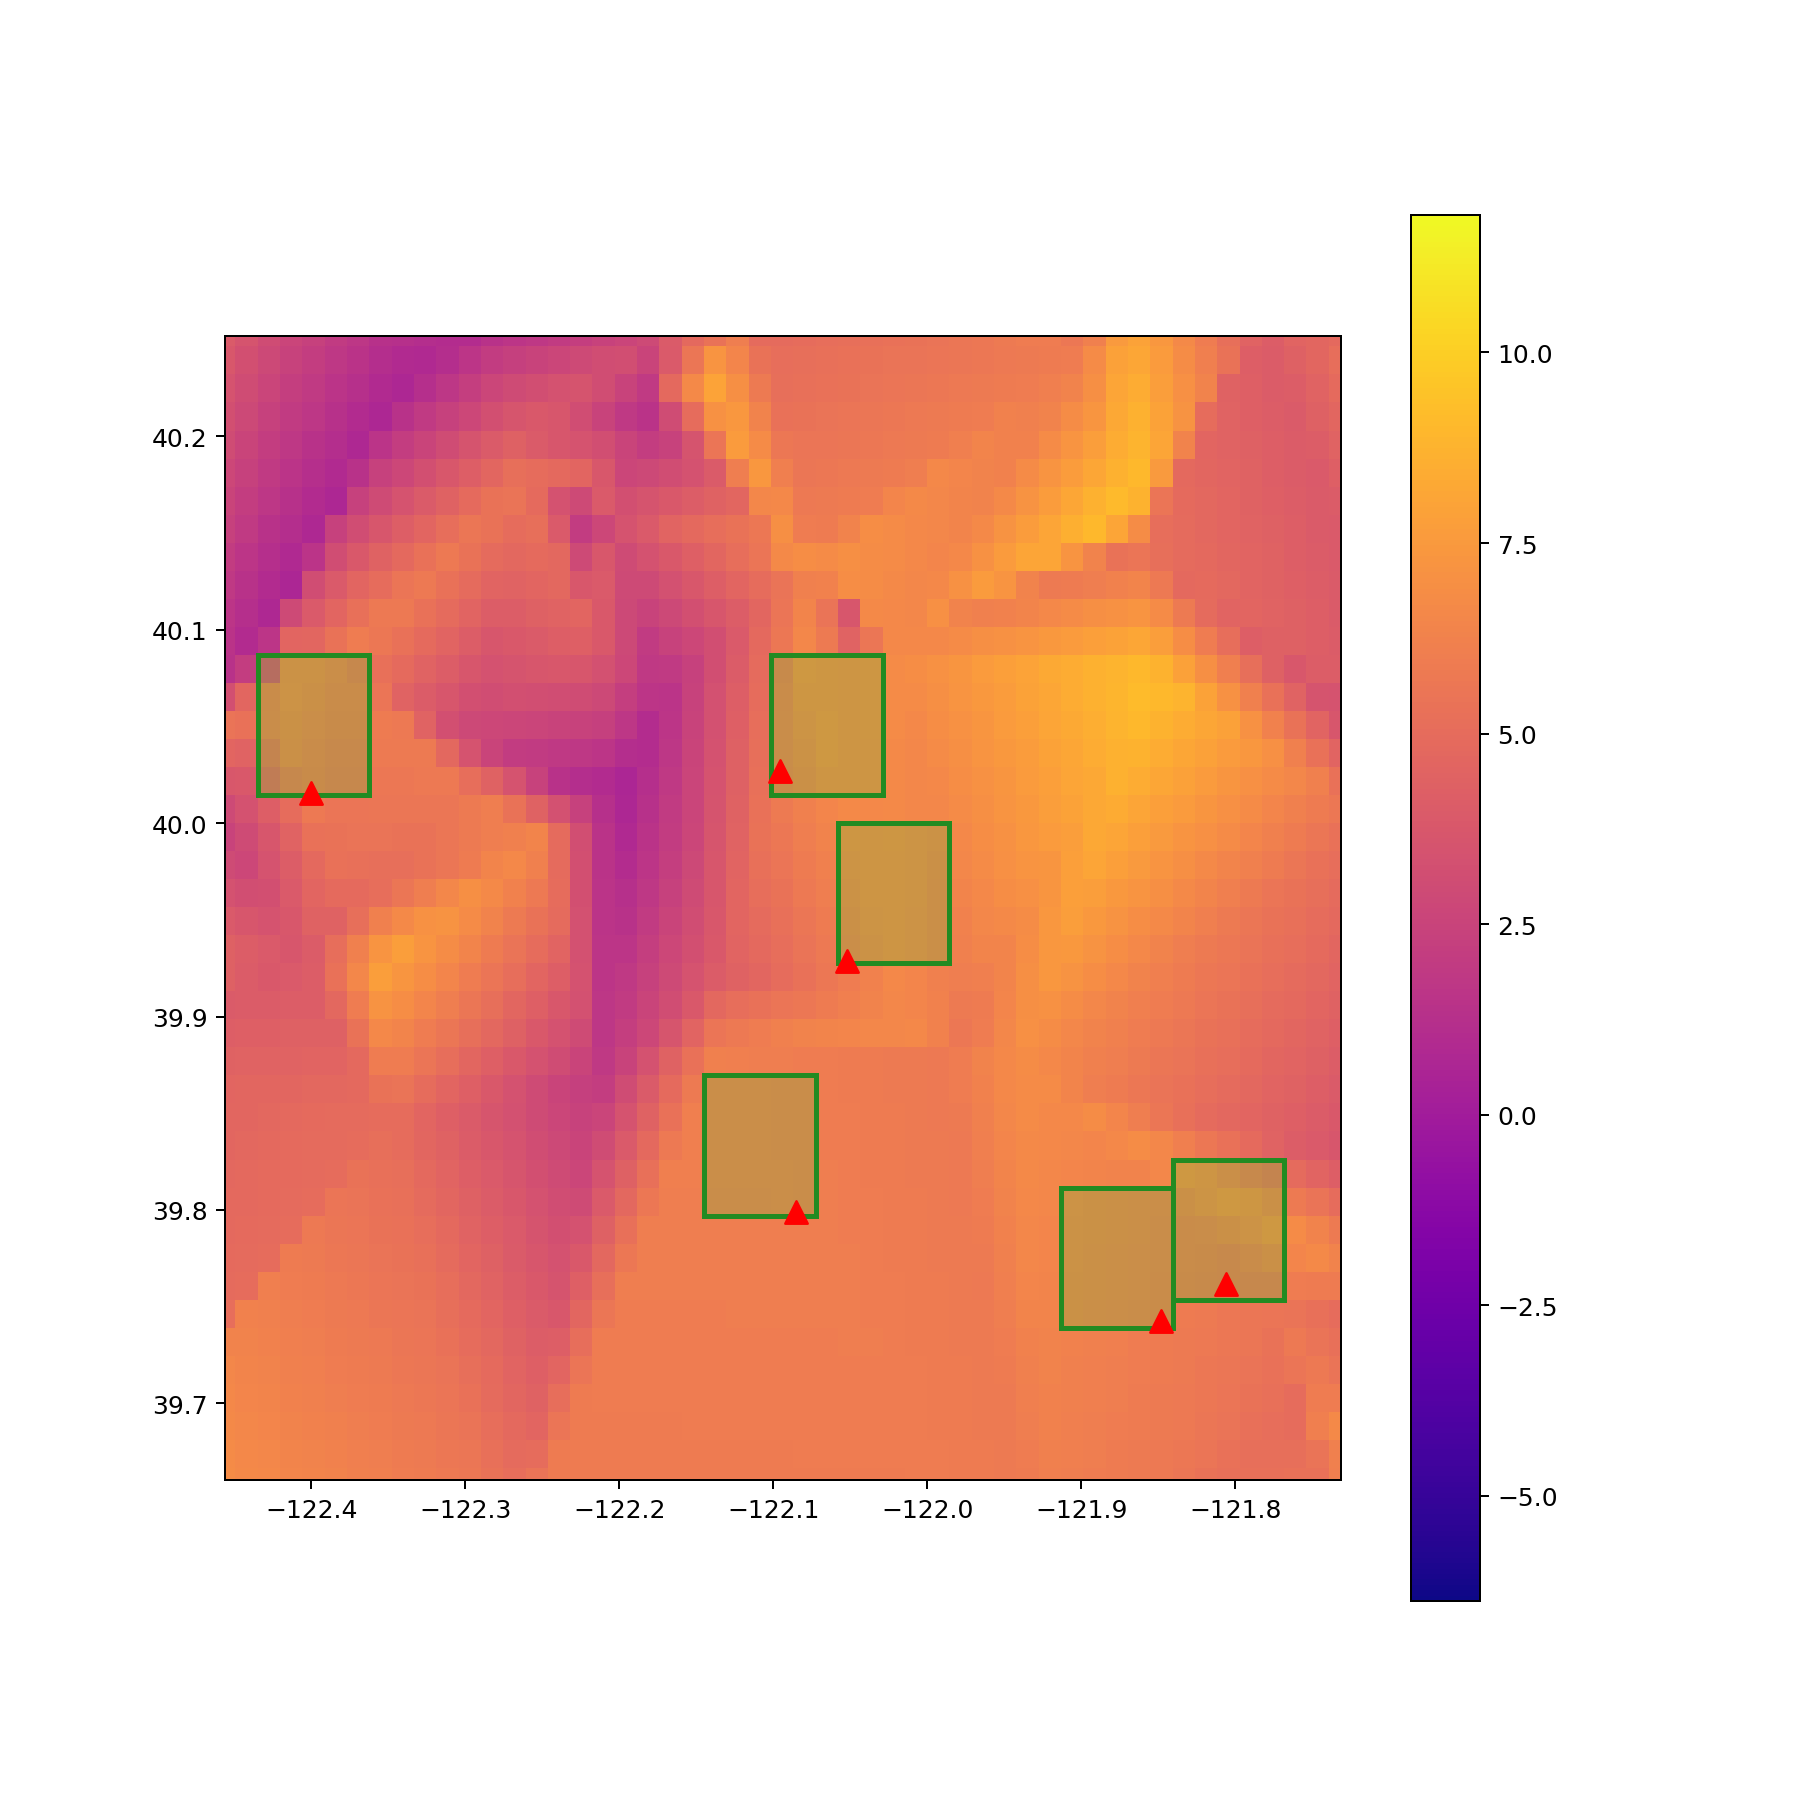

In [84]:
###### Plotting Coverages
from shapely.geometry import Polygon

%matplotlib notebook
filename = "./tradeoff_results/brute_force_optimization+linear_interpolation_log_shifted10000"
plot_coverages = []
with open(filename, 'rb') as fp:
    res = pickle.load(fp)
    plot_coverages = res[4][10][1]


# plot_coverages
n_cells = 828
dataframe_name = "./dataframes/2000-2019/linear_interpolation_log"
dataframe = pd.read_pickle(dataframe_name)
ax = free_plotter(dataframe)
world.to_crs(cell.crs).plot(ax= ax, color = "none", edgecolor = 'black', figsize = (8,8))
# fires.plot(ax = ax, color = "pink")
stations = []
for x in plot_coverages:
    if (x[3] not in stations):
        stations.append(x[3])
    indx = x[1]
    minx, miny, maxx, maxy = cell["geometry"][indx].bounds
    if (x[2] == 1):
        pos = (minx, miny)
    if (x[2] == 2):
        pos = (minx, maxy-5*12/n_cells)
    if (x[2] == 3):
        pos = (maxx-5*12/n_cells, maxy-5*12/n_cells)
    if (x[2] == 4):
        pos = (maxx-5*12/n_cells, miny)
    if (x[2] == 5):
        pos = (minx-2*12/n_cells, miny)
    if (x[2] == 6):
        pos = (minx-2*12/n_cells, maxy-5*12/n_cells)
    if (x[2] == 7):
        pos = (maxx-5*12/n_cells, miny-2*12/n_cells)
    if (x[2] == 8):
        pos = (minx, miny-2*12/n_cells)
    if (x[2] == 9):
        pos = (minx-2*12/n_cells, miny-2*12/n_cells)
#     rect = plt.Rectangle(pos, 5*12/n_cells, 5*12/n_cells, color="limegreen", linewidth=3, alpha = 0.2)
    rect = plt.Rectangle(pos, 5*12/n_cells, 5*12/n_cells, color = "limegreen", alpha = 0.2)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    
    rect = plt.Rectangle(pos, 5*12/n_cells, 5*12/n_cells, edgecolor = "forestgreen", facecolor = "none", linewidth=2)
    ax = ax or plt.gca()
    ax.add_patch(rect)
jsonfile = ('./mygeodata/fire_station_point.geojson')
fire_station_points = geopandas.read_file(jsonfile)
# fires[countcoveredchoose(plot_coverages)].plot(ax= ax, color = "red")
plt.scatter(fire_station_points.loc[stations]["geometry"].x, fire_station_points.loc[stations]["geometry"].y, s = 80, color="red", marker="^")

<IPython.core.display.Javascript object>


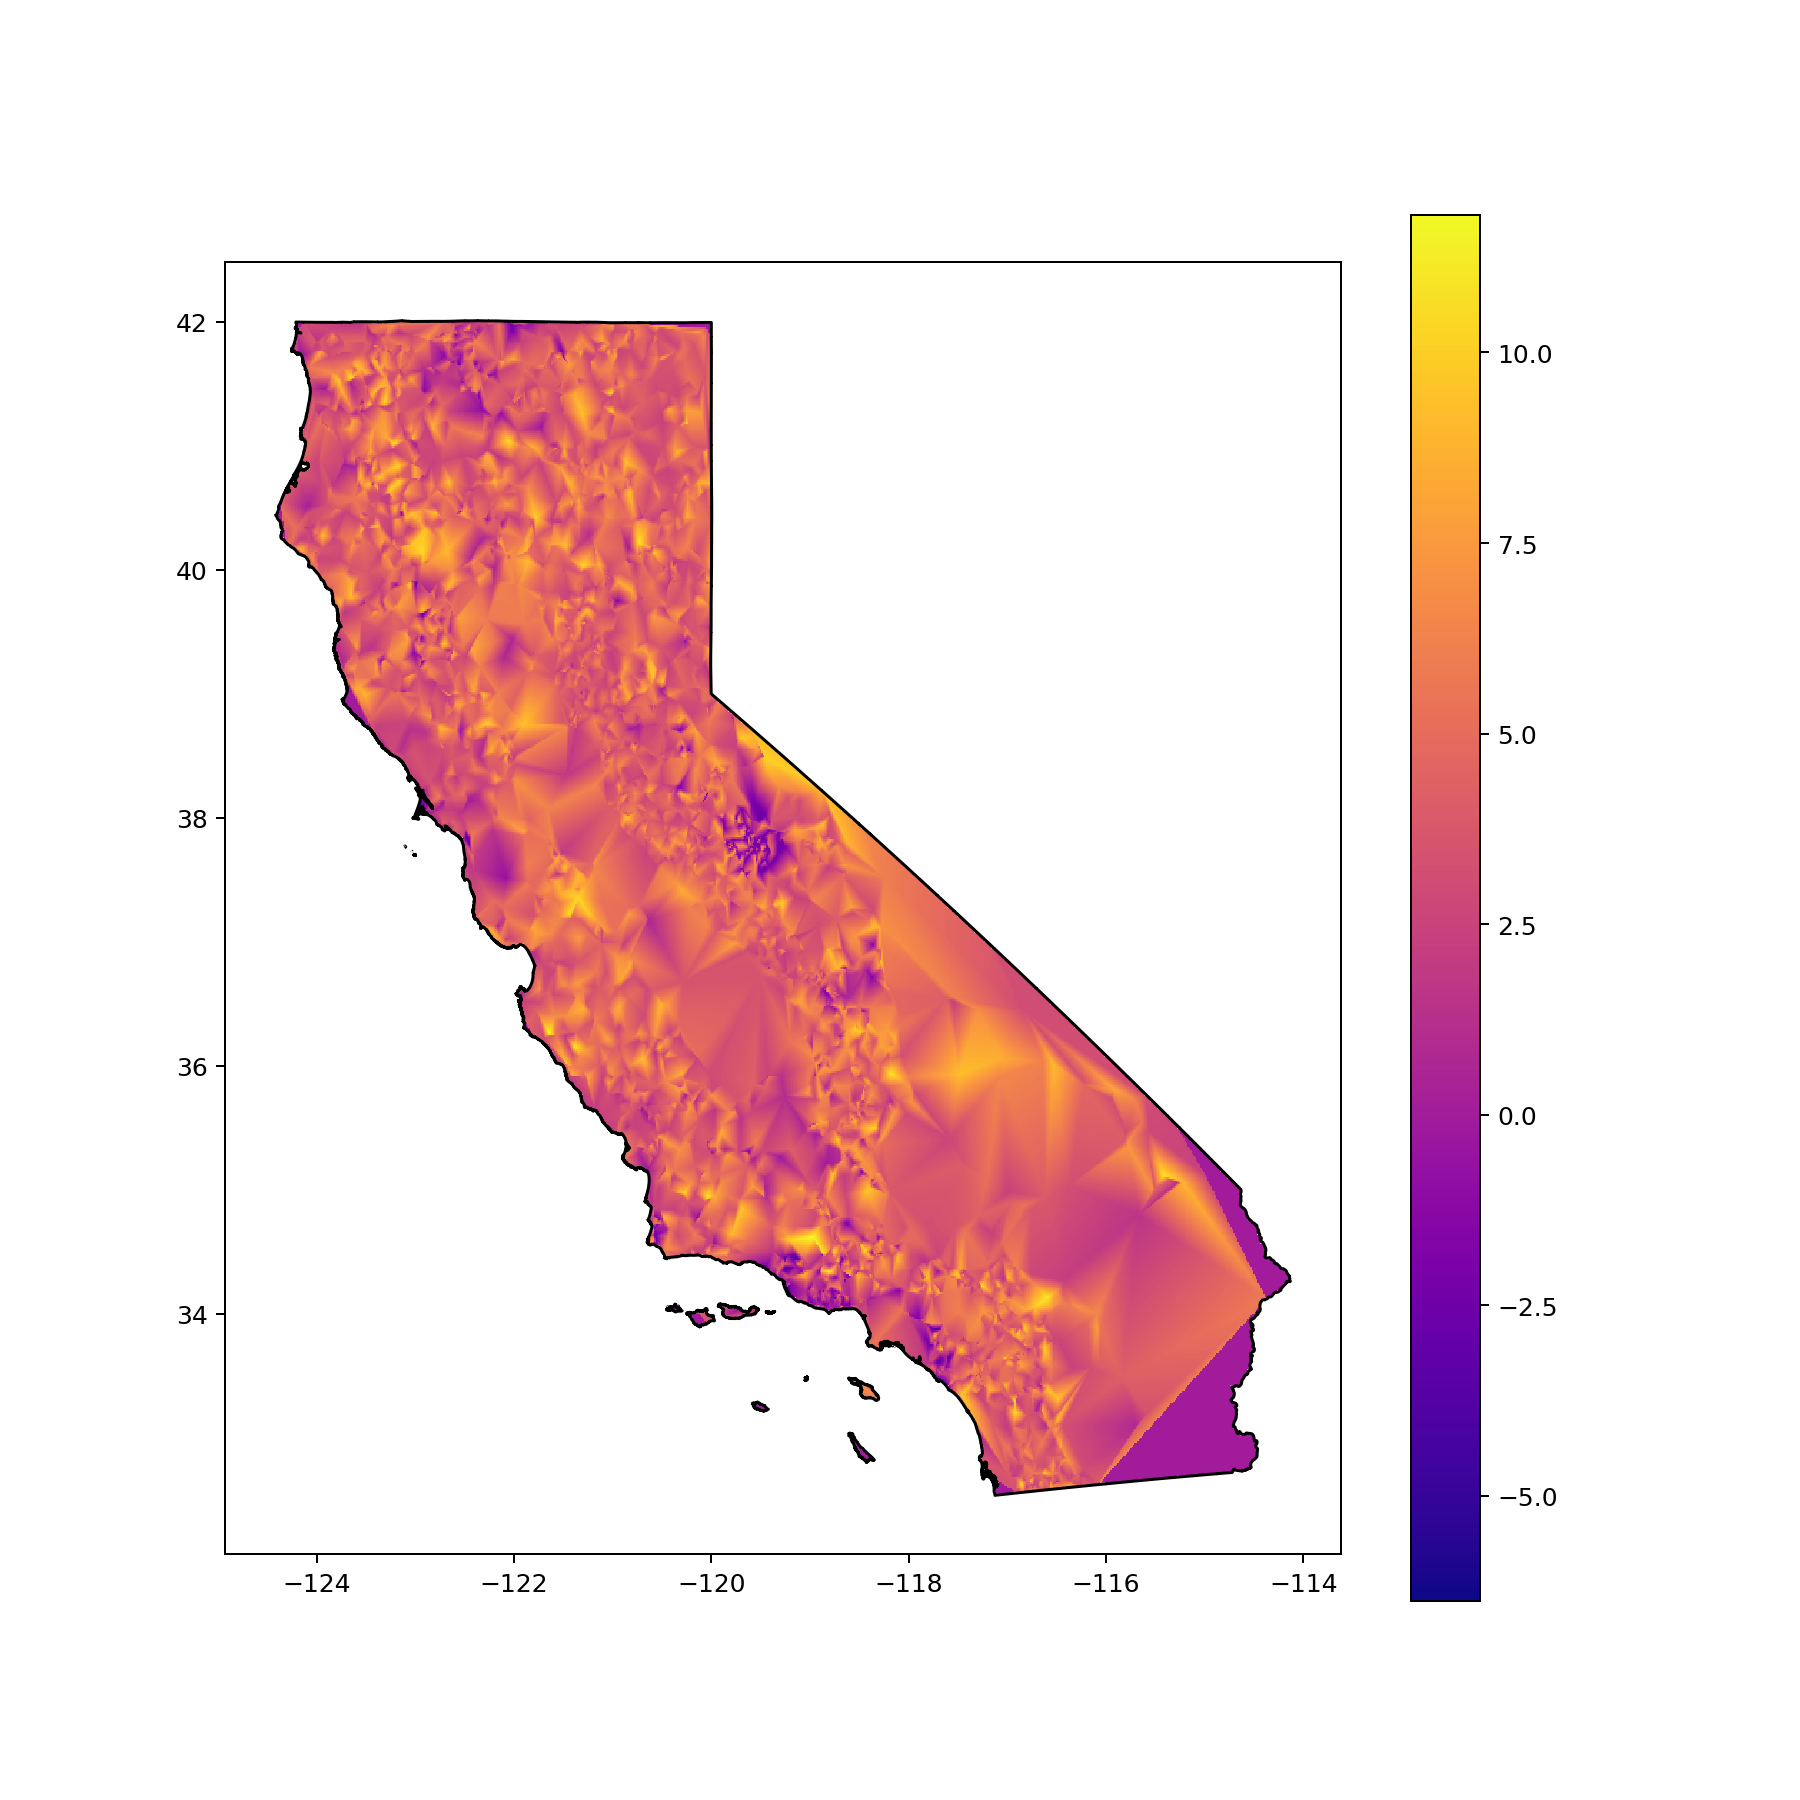

<Axes: >

In [61]:
dataframe_name = "./dataframes/2000-2019/linear_interpolation_log"
dataframe = pd.read_pickle(dataframe_name)
free_plotter(dataframe)

In [65]:
len(fires)

1451

In [66]:
np.sum(fires["GIS_ACRES"])

473360.980263412